<h1>Local setup with Anaconda</h1>
<p>You will need the following packages:<p>
<ol>
    <li><b>networkx:</b> <code>conda install networkx</code></li><br>
    <li><b>hiveplot:</b> <code>conda install -c conda-forge hiveplot</code></li><br>
    <li><b>nxviz:</b> <code>conda install -c conda-forge nxviz</code></li><br>
    <li><a href="https://github.com/taynaud/python-louvain"><b>python-louvain:</b></a><code>conda install python-louvain</code></li>
<ol>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statsmodels.api as sm

import networkx as nx
from nxviz import MatrixPlot, ArcPlot, CircosPlot
from hiveplot import HivePlot
import community 
import palettable as pal

%matplotlib inline

<h1>Loading datasets</h1>
<p>There are different file formats for storing network data and in most cases these data are divided into two files: one file contains edges and their attributes while the other contains nodes and their attributes.<br>
When loading the dataset, you have to decide which class of graphs to use based on the network structure you want to represent.
</p>
<p>
NetworkX provides the following classes:
<ul>
<li> Graph: undirected graphs with self loops </li>
<li> DiGraph: directed graphs with self loops </li>
<li> MultiGraph: undirected graphs with self loops and parallel edges </li>
<li> MultiDiGraph: directed graphs with self loops and parallel edges </li>
</ul>
</p>

In [30]:
def load_seventh_graders(communities=False):
    # Read the edge list
    df = pd.read_csv('data/seventh/out.moreno_seventh_seventh', skiprows=2, header=None, sep=' ')
    df.columns = ['student1', 'student2', 'count']

    # Read the node metadata
    nodeAttributes = pd.read_csv('data/seventh/ent.moreno_seventh_seventh.student.gender',header=None)
    nodeAttributes.index += 1
    nodeAttributes.columns = ['gender']
    
    # Construct graph from edge list.
    G = nx.DiGraph()
    for row in df.iterrows():
        G.add_edge(row[1]['student1'], row[1]['student2'], weight=row[1]['count'])
    
    # Add node attributes
    for n in G.nodes():
        (G.nodes[n])['gender'] = nodeAttributes.iloc[n-2]['gender']
        
    if communities:
        nx.set_node_attributes(G, community.best_partition(G),'group')
    
    return G

def load_windsurfer(communities=False):
    df = pd.read_csv('data/beach/out.moreno_beach_beach', skiprows=2, header=None, sep=' ')
    df.columns = ['surf1', 'surf2','weight']
    G = nx.from_pandas_edgelist(df, source='surf1', target='surf2',edge_attr='weight')
    
    if communities:
        nx.set_node_attributes(G, community.best_partition(G),'group')
            
    return G

def load_trainingbomb(communities=False):
    df = pd.read_csv('data/bombing/out.moreno_train_train', skiprows=2, header=None, sep=' ')
    df.columns = ['terrorist1', 'terrorist2','weight']
    G = nx.from_pandas_edgelist(df, source='terrorist1', target='terrorist2',edge_attr='weight')
    
    max_w = max(nx.get_edge_attributes(G, 'weight').values())
    normalized_w = {(v1,v2): 1 + (w['weight']/max_w) * 5 for v1,v2,w in G.edges(data=True)}
    nx.set_edge_attributes(G,normalized_w,'normalized_weight')
    
    if communities:
        nx.set_node_attributes(G, community.best_partition(G),'group')

    return G

def load_facebook(communities=False):
    df = pd.read_csv('data/facebook/out.ego-facebook', skiprows=2, header=None, sep=' ')
    df.columns = ['user1', 'user2']
    G = nx.from_pandas_edgelist(df, source='user1', target='user2')
    
    if communities:
        nx.set_node_attributes(G, community.best_partition(G),'group')
    
    return G

<a href="http://konect.uni-koblenz.de/networks/moreno_beach"><h2>Windsurfers dataset</h2></a>
<p>This undirected network contains interpersonal contacts between windsurfers in southern California during the fall of 1986.<br> A node represents a windsurfer and an edge between two windsurfers shows that there was a interpersonal contact.
</p>

In [31]:
G = load_trainingbomb(communities=True)
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 64
Number of edges: 243
Average degree:   7.5938


<h1>Graph visualization</h1>

<p>The most important thing regarding the traditional visualization of a graph is to assign the coordinates to each node. <br>
To obtain more pleasant visualizations, libraries such as NetworkX provide methods of graph layouts.
Some layout types are independent of connectivity patterns (random, circular, spiral, shell).<br>
Other layouts, on the other hand, are based on physical models in which each node has an electric charge and applies repulsive force towards the other nodes. The edges instead simulate an elastic force that attracts adjacent nodes.
The model iteratively determines the resulting forces acting on the nodes and attempts to bring the nodes closer to a balance in which all forces add up to zero and the position of the nodes remains stable. These layouts are called <b>force-directed layouts</b>  (Kamada-Kawai, spring, spectral).</p>
<p>If the network is large, visualizations begin to look like <b>hairballs</b> and you can not get any useful information about its features. <br> So there are other ways to visualize networks following a <b>rational visualization approach</b>: arc plots, circus plots and hive plots. <br> The principle behind <b>rational visualization</b> is to prioritize the placement of nodes in a certain way and then look at the edges and how they are structured according to the organization of the nodes.</p>

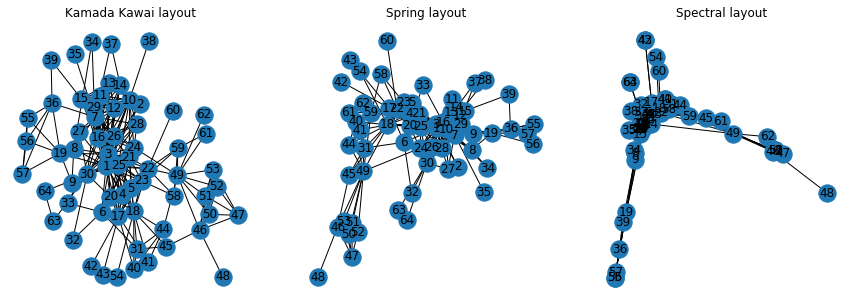

In [32]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("Kamada Kawai layout")
nx.draw_kamada_kawai(G, with_labels=True)

plt.subplot(1,3,2)
nx.draw_spring(G, with_labels=True)
plt.title("Spring layout")

plt.subplot(1,3,3)
nx.draw_spectral(G, with_labels=True)
plt.title("Spectral layout")

plt.show()

<h2>Arc plot</h2>
<p>In arc diagrams, nodes are displayed along a single axis and links are represented with arcs.<br>Nodes can be grouped or ordered by a criteria in order to visualize the <b>density</b> of the connections between groups.</p>

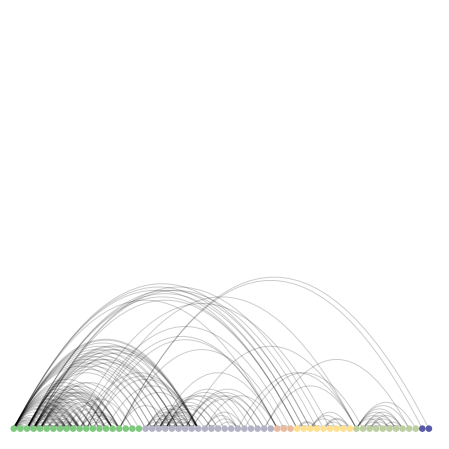

In [33]:
a = ArcPlot(G, node_color='group', node_grouping='group', figsize=(8,8), edge_width='weight')
a.draw()

<h2>Circos plot</h2>
<p>This visualization helps us highlight nodes that there are <b>poorly connected</b>, and others that are <b>strongly connected</b>.</p>

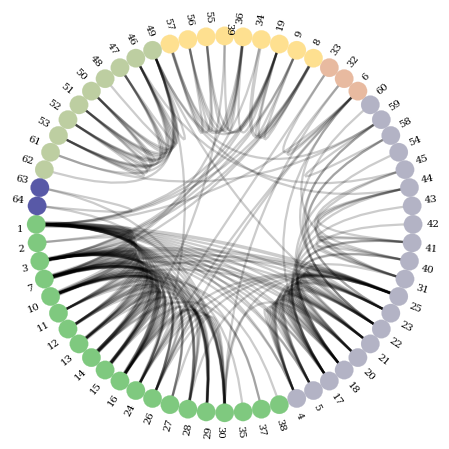

In [34]:
c = CircosPlot(G, node_color='group', node_grouping='group', node_labels=True, figsize=(8,8),
               node_label_layout='rotation', fontsize=10, edge_width="normalized_weight")
c.draw()

<h2>Hiveplots</h2>
<p>Hive plots allow us to divide our nodes into sub-groups, and visualize the within- and between-group connectivity.</p>

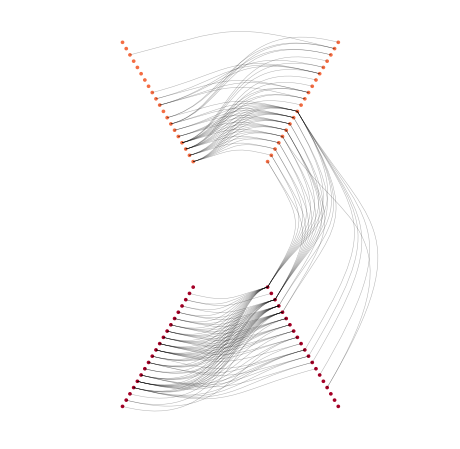

In [35]:
colors=['#a50026','#f46d43','#fee090','#abd9e9','#313695','#762a83','#1b7837','#dfc27d']
groups=list(pd.Series(community.best_partition(G)).value_counts()[:2].index)
nodes = dict()
nodes_cmap = dict()
for i in groups:
    nodes[i] = [n for n,d in G.nodes(data=True) if d['group'] == i]
    nodes_cmap[i] = colors[i]

edges_cmap = {'group1':'black'}
edges = dict()
edges['group1'] = G.subgraph([n for n in G.nodes() if (G.nodes()[n]['group'] in groups)]).edges(data=True)

h = HivePlot(nodes, edges, nodes_cmap, edges_cmap)
h.draw()

<h2>Adjacency matrix</h2>

Another way to analyze graphs when they are large is to use <b>adjacency matrices</b>. However, adjacency matrices for large graphs are often sparse matrices and show no connectivity patterns. Then algorithms that permute rows and columns (bandwidth reduction permutations) are used, following optimization procedures (minimum degree ordering, reverse Cuthill-McKee ordering) and showing connectivity patterns (for example tightly connected groups of nodes).

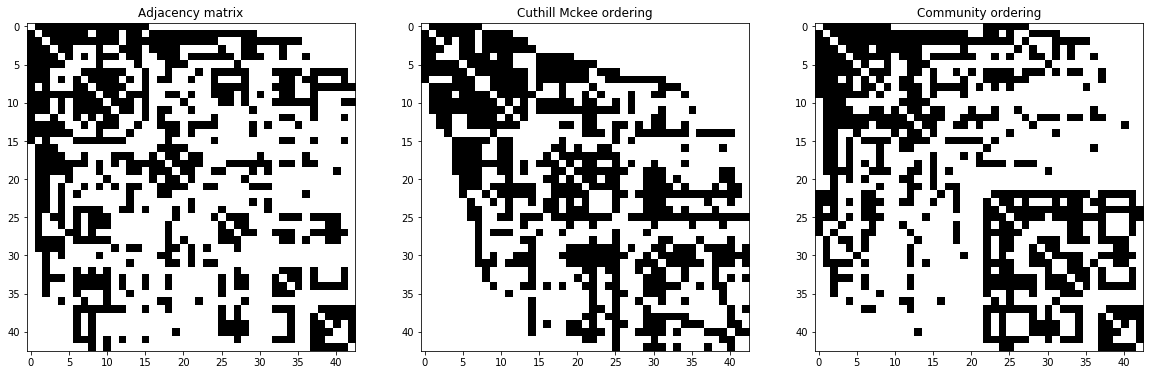

In [36]:
from networkx.utils import cuthill_mckee_ordering
from collections import defaultdict

def draw_adjacency_matrix(G, node_order=None, partitions=[]):
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)
    plt.imshow(adjacency_matrix, cmap="Greys")

G = load_windsurfer()

plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
draw_adjacency_matrix(G)
plt.title("Adjacency matrix")

plt.subplot(1, 3, 2)
rcm = list(cuthill_mckee_ordering(G))
draw_adjacency_matrix(G, node_order=rcm)
plt.title("Cuthill Mckee ordering")

plt.subplot(1, 3, 3)

communities = defaultdict(list)
for n_index, comm_id in community.best_partition(G).items():
    communities[comm_id].append(n_index)
communities = communities.values()

nodes_comm_ordered = [node for comm in communities for node in comm]

draw_adjacency_matrix(G, nodes_comm_ordered, [communities])
plt.title("Community ordering")

plt.show()

<a href="http://konect.uni-koblenz.de/networks/moreno_train"><h2>Train bombing dataset</h2></a>
<p>This undirected network contains contacts between suspected terrorists involved in the train bombing of Madrid on March 11, 2004 as reconstructed from newspapers. A node represents a terrorist and an edge between two terrorists shows that there was a contact between the two terroists. The edge weights denote how 'strong' a connection was. This includes friendship and co-participating in training camps or previous attacks.</p>

In [52]:
df = pd.read_csv('data/out.moreno_train_train', skiprows=2, header=None, sep=' ')
df.columns = ['terrorist1', 'terrorist2','weight']
G = nx.from_pandas_edgelist(df, source='terrorist1', target='terrorist2',edge_attr='weight')
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 64
Number of edges: 243
Average degree:   7.5938


<p>We can see with the following visualization which are the most influential and active terrorists.</p>

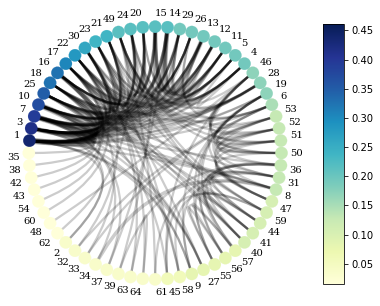

In [37]:
G = load_trainingbomb(communities=True)

centr = {k: v for k, v in  nx.degree_centrality(G).items()}
for n in centr:
    G.nodes[n]['centrality'] =  centr[n]
c = CircosPlot(G, node_color='centrality', node_grouping='centrality', node_labels=True, edge_width="normalized_weight")
c.draw()

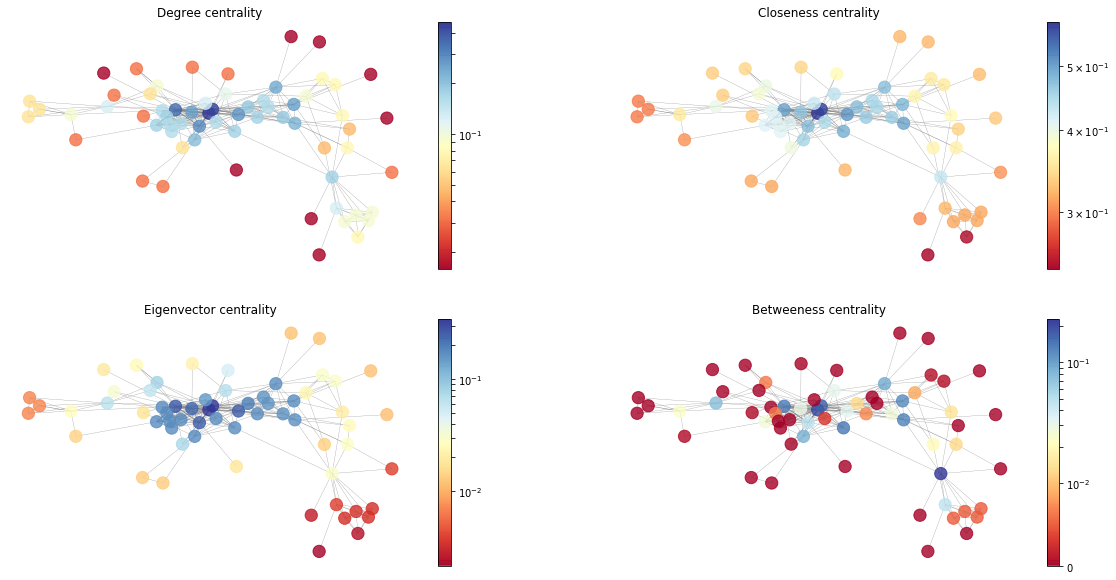

In [38]:
#We define here a function that will serve us throughout this presentation.
#This function allows you to draw a graph by coloring the nodes according to the value of a measurement.
def draw_measure(G, pos, title, node_size, cmap, measure, show=False, scale_color=True, color_bar=True):

    if measure: 
        nodes =  nx.draw_networkx_nodes(G, pos, node_size=node_size, cmap=cmap, alpha=.8,
                                   node_color=list(map(float,measure.values())),
                                   nodelist=list(map(float,measure.keys())))
    else:
        nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size)
                
    if scale_color:
        nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    
    edge_width = [0.25 * G[u][v]['weight'] for u,v in G.edges()]
    edges = nx.draw_networkx_edges(G, pos, edge_color= "gray", width=edge_width)

    plt.title(title)
    
    if color_bar:
        plt.colorbar(nodes)
        
    plt.axis('off')
    
    if show:
        plt.show()

pos = nx.spring_layout(G)
cmap = pal.colorbrewer.diverging.RdYlBu_11.mpl_colormap
node_size=150


plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)

nodes = nx.draw_networkx_nodes(G, pos, node_size=150, cmap=plt.cm.viridis, 
                                   node_color=list(map(float,nx.degree_centrality(G).values())),
                                   nodelist=list(map(float,nx.degree_centrality(G).keys())))

nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
edges = nx.draw_networkx_edges(G, pos, edge_color= "gray", width=.5)

plt.title('Degree Centrality')
plt.colorbar(nodes)
plt.axis('off')

plt.subplot(2, 2, 2)

nodes = nx.draw_networkx_nodes(G, pos, node_size=150, cmap=plt.cm.viridis, 
                                   node_color=list(map(float,nx.closeness_centrality(G).values())),
                                   nodelist=list(map(float,nx.closeness_centrality(G).keys())))

plt.subplot(2, 2, 4)
draw_measure(G, pos, 'Betweeness centrality', node_size, cmap, nx.betweenness_centrality(G), show=True)

We can load the Seventh graders dataset and see how the HITS algorithm divides nodes according to their role as hub or authority.

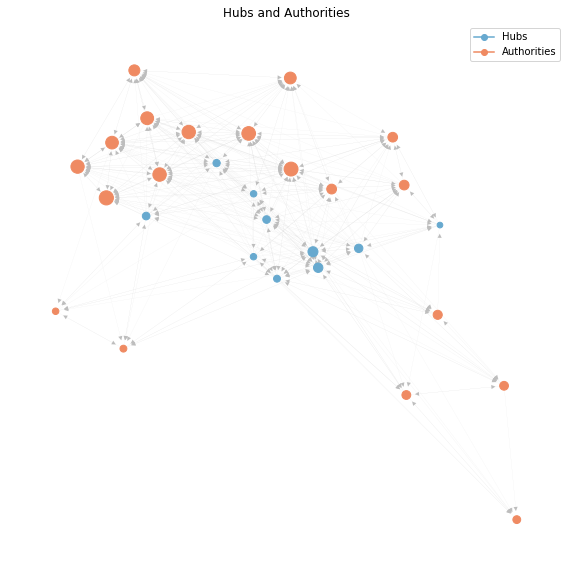

In [39]:
from matplotlib.lines import Line2D

plt.title('closeness_centrality')
plt.colorbar(nodes)
plt.axis('off')

plt.subplot(2, 2, 3)

nodes = nx.draw_networkx_nodes(G, pos, node_size=150, cmap=plt.cm.viridis, 
                                   node_color=list(map(float,nx.eigenvector_centrality(G).values())),
                                   nodelist=list(map(float,nx.eigenvector_centrality(G).keys())))

plt.figure(figsize=(10, 10))

plt.title('Eigenvector Centrality')
plt.colorbar(nodes)
plt.axis('off')


max_authorities = max(authorities.values())
size = [v*200/max_authorities  for k, v in authorities.items()]
nodes = nx.draw_networkx_nodes(authorities, pos, node_size=size, node_color='#ef8a62')

nodes = nx.draw_networkx_nodes(G, pos, node_size=150, cmap=plt.cm.viridis, 
                                   node_color=list(map(float,nx. nx.betweenness_centrality(G).values())),
                                   nodelist=list(map(float,nx. nx.betweenness_centrality(G).keys())))

nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
edges = nx.draw_networkx_edges(G, pos, edge_color= "gray", width =.5)

plt.title('Betweeness Centrality')
plt.colorbar(nodes)
plt.axis('off')




plt.show()

In [16]:
sorted(G.nodes(),key=lambda x:len(list(G.neighbors(x))), reverse=True)[0:5]

[1, 3, 7, 10, 25]

In [40]:
G = load_facebook(communities=True)
print(nx.info(G))

[(1, 0.4603174603174603),
 (3, 0.42857142857142855),
 (7, 0.3492063492063492),
 (10, 0.2857142857142857),
 (25, 0.2698412698412698)]

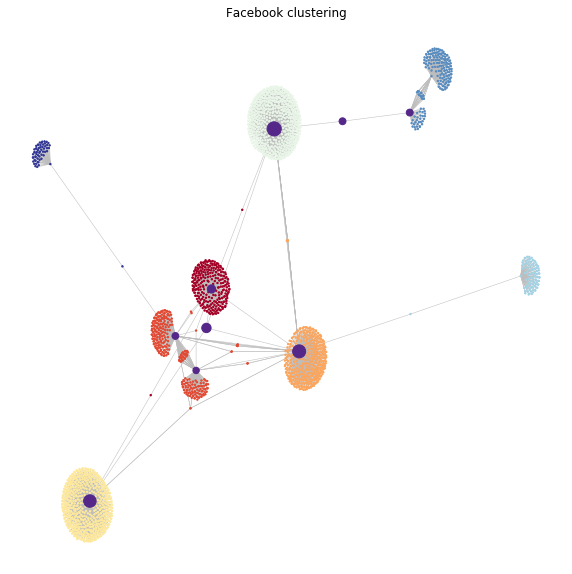

In [41]:
plt.figure(figsize=(10, 10))

pos = nx.spring_layout(G)

cmap = pal.colorbrewer.diverging.RdYlBu_11.mpl_colormap
nodes = nx.draw_networkx_nodes(G, pos, node_size=2, cmap=cmap, 
                                   node_color=list(map(float,dict(G.nodes.data(data='group')).values())),
                                   nodelist=list(map(float,dict(G.nodes.data(data='group')).keys())))

edges = nx.draw_networkx_edges(G, pos, edge_color= "#bdbdbd", width =.5)

high_betweenness = {k: v for k, v in nx.betweenness_centrality(G, normalized=True).items() if v > 0.1}
pos_high_bet = {k: pos[k] for k, _ in high_betweenness.items()}
group_bet = {k: G.nodes(data=True)[k]['group'] for k, _ in high_betweenness.items()}
node_bet_size = [ v*200/max(high_betweenness.values()) for v in high_betweenness.values()]
nodes = nx.draw_networkx_nodes(high_betweenness, pos_high_bet, node_size=node_bet_size,
                                   node_color='#542788')

plt.title('Facebook clustering')
plt.axis('off')
plt.savefig('images/facebook.png', dpi=300)
plt.show()